Generation Maze by Recursive Backtracking

    The maze always have one enter and one exit and one path is guaranteed, everithing else is random. The size must be odd to work properly. The allowed cells are 0, walls are 1.

In [38]:
import numpy as np
import random

def carve_passages_from(maze, x, y):
    maze[y, x] = 0
    directions = [(0, -2), (0, 2), (-2, 0), (2, 0)]
    random.shuffle(directions)

    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 < nx < maze.shape[1] and 0 < ny < maze.shape[0] and maze[ny, nx] == 1:
            maze[y + dy//2, x + dx//2] = 0
            carve_passages_from(maze, nx, ny)

def generate_maze(width, height):
    if width % 2 == 0 or height % 2 == 0:
        raise ValueError("Width and height must be odd.")

    maze = np.ones((height, width), dtype=int)
    start = (1, 0)
    end = (height - 2, width - 1)

    maze[start[0], start[1]] = 0
    maze[end[0], end[1]] = 0

    carve_passages_from(maze, random.randrange(1, width, 2), random.randrange(1, height, 2))

    return maze

def save_mazes_to_file(filename, num_mazes, width, height):
    with open(filename, 'w') as file:
        for i in range(num_mazes):
            maze = generate_maze(width, height)
            for row in maze:
                file.write(" ".join(str(cell) for cell in row) + "\n")
            file.write("\n")

width, height = 11, 11
save_mazes_to_file("output", 1, width, height)
maze = generate_maze(width, height)
print(maze)

[[1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 0 0 0 0 0 1]
 [1 0 1 0 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 1]
 [1 0 1 1 1 1 1 1 1 0 1]
 [1 0 1 0 1 0 0 0 0 0 1]
 [1 0 1 0 1 1 1 0 1 1 1]
 [1 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 1 1 0 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1]]


Ant Colony Optimization

The main parameters of the function:

maze - two-dimensional array representing a maze,

start - the starting point of the path (coordinates),

end - the endpoint of the path (coordinates),

ants - the number of ants in the colony (default is 20),

iterations - the number of iterations of the algorithm (default is 100),

evaporation - the pheromone evaporation coefficient (0.5 by default),

alpha and beta - the parameters of the pheromone effect and distance on the path selection,

q0 - probability of greedily selecting the next cell (0.9 by default).

The algorithm works as follows:

1. A pheromone matrix is initialized for all possible transitions between cells with a small initial value.

2. In each iteration:
Each ant constructs a path from start to finish by moving to adjacent cells. At each step, the next cell is selected either greedily (with probability q0) or probabilistically based on pheromone levels and heuristic distance to target.

3. Ants avoid revisiting cells by maintaining a tabu list of visited positions.

4. When ants complete their paths, the pheromone matrix is updated: all pheromones evaporate, and ants that reached the finish deposit pheromones inversely proportional to their path length.

5. After all iterations complete, the shortest valid path found is returned as the solution.

In [39]:
from collections import defaultdict
class ACO:
    def __init__(self, maze, start, end,
                 ants=20, iterations=100,
                 evaporation=0.5, alpha=1, beta=3,
                 q0=0.9, pheromone_init=0.1):
        self.maze = maze
        self.start = start
        self.end = end
        self.ants = ants
        self.iterations = iterations
        self.evaporation = evaporation
        self.alpha = alpha  # influence of pheromones
        self.beta = beta    # influence of heuristics
        self.q0 = q0        # the probability of a greedy choice
        self.height, self.width = maze.shape

        # Initialization of pheromones at the edges
        self.pheromones = defaultdict(lambda: pheromone_init)

        # Possible movements
        self.directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Heuristic: inverse distance to exit (Manhattan)
    def heuristic(self, pos):
        return 1 / (abs(pos[0] - self.end[0]) + abs(pos[1] - self.end[1]) + 1)

    # The probability of moving to the next cell
    def transition_probability(self, current, neighbor):
        edge = (current, neighbor)
        tau = self.pheromones[edge] ** self.alpha
        eta = self.heuristic(neighbor) ** self.beta
        return tau * eta

    def run(self):
        best_path = None
        best_length = float('inf')

        for _ in range(self.iterations):
            paths = []
            path_lengths = []

            for _ in range(self.ants):
                path = [self.start]
                visited = set([self.start])
                current = self.start

                while current != self.end:
                    neighbors = []
                    probabilities = []

                    # We get acceptable neighbors
                    for dy, dx in self.directions:
                        ny, nx = current[0] + dy, current[1] + dx
                        if (0 <= ny < self.height and 0 <= nx < self.width and
                            self.maze[ny, nx] == 0 and (ny, nx) not in visited):
                            neighbors.append((ny, nx))

                    if not neighbors:
                        break  # Dead end

                    # Greedy choice with probability q0
                    if random.random() < self.q0:
                        next_pos = max(neighbors,
                                     key=lambda x: self.transition_probability(current, x))
                    else:
                        # Probabilistic choice
                        total = sum(self.transition_probability(current, n) for n in neighbors)
                        probs = [self.transition_probability(current, n)/total for n in neighbors]
                        next_pos = neighbors[np.random.choice(len(neighbors), p=probs)]

                    path.append(next_pos)
                    visited.add(next_pos)
                    current = next_pos

                if current == self.end:
                    paths.append(path)
                    length = len(path)
                    path_lengths.append(length)

                    if length < best_length:
                        best_path = path
                        best_length = length

            # Evaporation of pheromones
            for edge in self.pheromones:
                self.pheromones[edge] *= self.evaporation

            # Pheromone renewal on better paths
            for path, length in zip(paths, path_lengths):
                for i in range(len(path)-1):
                    edge = (path[i], path[i+1])
                    self.pheromones[edge] += 1 / length
        return best_path


start = (1, 0)
end = (height - 2, width - 1)

aco = ACO(maze, start, end, ants=30, iterations=100)
solution_path = aco.run()

if solution_path:
    print("Решение найдено.")
else:
    print("Решение не найдено.")

Решение найдено.


Visualization via Matplotlib

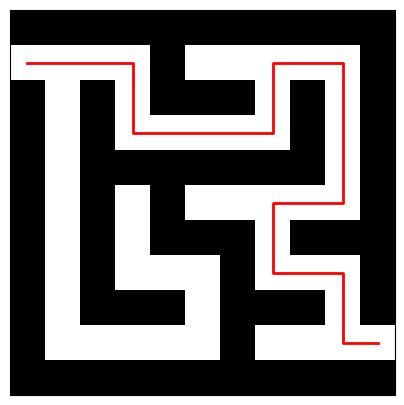

In [40]:
from os import path
import matplotlib.pyplot as plt

def plot_maze_with_path(maze, path):
    plt.figure(figsize=(5, 5))
    plt.imshow(maze, cmap='binary')
    if path:
        y_coords, x_coords = zip(*path)
        plt.plot(x_coords, y_coords, color='red', linewidth=2)
    plt.xticks([]), plt.yticks([])
    plt.show()

plot_maze_with_path(maze, solution_path)

Genetic Algorithm

Speciman - an individual in population, contains a solution and fitness

Maze - a labyrinth, contains start and end coordintaes

solveMaze() - the main function that accepts maze, population size, max generations and epoches. Output either a solution or "no solution".

findStartAndFinish() - accepts a maze, define start and end points.

epoch() - perform one cycle of evolution.
In each generations:
1. Perform fitness function and sort by it.
2. Perform selection: crossover and mutation

The goal is to find the most optimal (the shortest) path until max epoches are achived

[[1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 0 0 0 0 0 1]
 [1 0 1 0 1 1 1 0 1 0 1]
 [1 0 1 0 0 0 0 0 1 0 1]
 [1 0 1 1 1 1 1 1 1 0 1]
 [1 0 1 0 1 0 0 0 0 0 1]
 [1 0 1 0 1 1 1 0 1 1 1]
 [1 0 1 0 0 0 1 0 0 0 1]
 [1 0 1 1 1 0 1 1 1 0 1]
 [1 0 0 0 0 0 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1]]

Epoch 1
Solution: [(1, 0), (1, 1), (1, 3), (3, 3), (3, 7), (1, 7), (1, 9), (5, 9), (5, 7), (7, 7), (7, 9), (9, 9), (9, 10)]


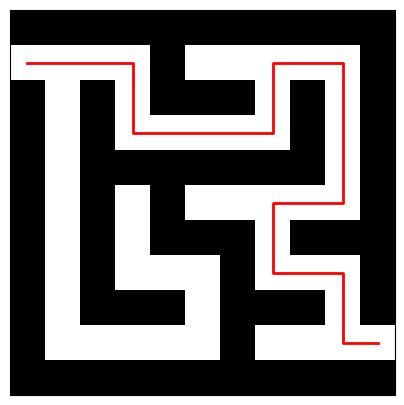

In [41]:
import numpy as np
import random
import matplotlib.pyplot as plt

class Specimen:
    def __init__(self, solution, fitness = 1000, type = "h"):
        self.solution = solution
        self.fitness = fitness
        self.type = type

class Maze:
    def __init__(self, maze, s, f):
        self.maze = maze
        self.start = s
        self.finish = f

def solveMaze(maze, population_size, max_generations, epochs):
    start, finish, actualStart, actualFinish = findStartAndFinish(maze)
    currentMaze = Maze(maze, start, finish)
    # bestOnes = []
    for e in range(epochs):
        someone = epoch(currentMaze, population_size, max_generations)
        print("Epoch", e+1)
        if someone.fitness != -1:
            # bestOnes.append(someone)
            actualPath = makePath(maze.copy(), someone)
            print("Solution:", actualPath)
            plot_maze_with_path(maze, actualPath)
        else:
            print("No solution found!")
            print("Best solution:", someone.solution)
        print()

# returns global normalizable coordinates of start and finish, then borders(entry and exit)
def findStartAndFinish(maze) -> [tuple(), tuple(), tuple(), tuple()]:
    h, l = maze.shape
    sf = [tuple([1, 1]), tuple([h-2, l-2]), tuple([1, 1]), tuple([h-2, l-2])]
    isStart = True
    for i in range(h):
        for j in range(l):
            if i == 0 or i == h-1 or j == 0 or j == l-1:
                if str(maze[i][j]) == "0":
                    index = 1
                    if isStart:
                        index = 0
                        isStart = False
                    sf[index + 2] = tuple([i, j])
                    if i == 0:
                        sf[index] = tuple([i+1, j])
                    elif i == h-1:
                        sf[index] = tuple([i-1, j])
                    elif j == 0:
                        sf[index] = tuple([i, j+1])
                    elif j == l-1:
                        sf[index] = tuple([i, j-1])
                    else:
                        print("error start:", i, j)
    return sf

# done, too complex to explain
def epoch(mmaze, population_size, generations):
    size = fromGToNTuple(mmaze.maze.shape) # normalize maze size
    solutionSize = max(size) # solution size
    origSize = solutionSize # for future checks
    while True:
        population = initPopulation(mmaze, population_size, solutionSize) # initialize population
        for g in range(generations): #for every generation:
            ll = population_size
            for i in range(ll): # calculate fitness
                population[i].fitness, population[i].type = computeFitness(mmaze, population[i].solution.copy())
            population = sorted(population.copy(), key=lambda x: x.fitness)
            if population[0].fitness == 0: # if solved, break 'for' cycle
                break
            newPop = [] # perform selection
            bests = max(round(ll * 0.1), 2)
            averages = min(max(2, round(ll * 0.5)), ll - bests)
            randoms = ll - bests - averages
            for i in range(bests): # append best species(2+) from last generation
                newPop.append(population.copy()[i])
            newPop.append(mutation(crossover(population.copy()[0], population.copy()[1]), size, 0.2)) # perform crossover and mutation
            for i in range(averages - 1):
                newPop.append(crossover(population.copy()[0], population.copy()[1 + bests + i]))
            for i in range(bests + averages, bests + averages + randoms):
                newPop.append(mutation(population.copy()[i], size, 1))
            while len(newPop) < len(population.copy()): # if somehow there is not full population
                newPop.append(mutation(population.copy()[-1], size, 1))
            population = newPop.copy()
        # generations performed
        if population[0].fitness != 0 and solutionSize >= origSize: # if not solved for size, increase solution size
            print("Too small solution of", solutionSize, "points")
            solutionSize += 1
            if solutionSize >= (origSize) ** 2:
                print("No solution found!")
                return Specimen(population.copy()[0].solution, -1)
        else:
            if population[0].fitness != 0: # if solutionSize was decreased and not solved, return the shortest one
                return bestOne
            else: # if solved, trying to find shorter solution
                bestOne = population.copy()[0]
                solutionSize -= 1

# initializes pop_size Specimens with normalized solutions
def initPopulation(mmaze, pop_size, sol_size):
    population = []
    size = mmaze.maze.shape
    normalSize = fromGToNTuple(size)
    for i in range(pop_size):
        sol = []
        for j in range(sol_size): #works
            sol.append(tuple([random.randint(0, normalSize[0]-1), random.randint(0, normalSize[1]-1)]))
        fit, type = computeFitness(mmaze, sol.copy())
        population.append(Specimen(sol.copy(), fit, type))
    return population.copy()

# solution in normal format, then everything is normalized and solved
def computeFitness(mmaze, solution) -> [int, str]:
    v = verticalFirst(mmaze, solution)
    h = horizontalFirst(mmaze, solution)
    if v < h:
        return [v, "v"]
    return [h, "h"]

def verticalFirst(mmaze, solution) -> int:
    crosses = 0
    s = len(solution)
    currentPosition = fromGToNTuple(mmaze.start)
    finish = fromGToNTuple(mmaze.finish)
    for i in range(s):
        goal = solution[i]
        lineGoal = (goal[0], currentPosition[1])
        crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
        currentPosition = lineGoal
        lineGoal = goal
        crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
        currentPosition = goal
    goal = finish
    lineGoal = (goal[0], currentPosition[1])
    crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
    currentPosition = lineGoal
    lineGoal = goal
    crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
    currentPosition = goal
    return crosses

def horizontalFirst(mmaze, solution) -> int:
    crosses = 0
    s = len(solution)
    currentPosition = fromGToNTuple(mmaze.start)
    finish = fromGToNTuple(mmaze.finish)
    for i in range(s):
        goal = solution[i]
        lineGoal = (currentPosition[0], goal[1])
        crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
        currentPosition = lineGoal
        lineGoal = goal
        crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
        currentPosition = goal
    goal = finish
    lineGoal = (currentPosition[0], goal[1])
    crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
    currentPosition = lineGoal
    lineGoal = goal
    crosses += computeLine(mmaze.maze, currentPosition, lineGoal)
    currentPosition = goal
    return crosses

# send normal positions on same line/column to get n of walls crossed
def computeLine(maze, position, goal):
    crosses = 0
    x1, y1 = position
    x2, y2 = goal
    # print("Normalized position goal")
    # print(f"x1 {x1}, y1 {y1} \nx2 {x2}, y2 {y2}")
    x1 = fromNToGCoord(x1)
    x2 = fromNToGCoord(x2)
    y1 = fromNToGCoord(y1)
    y2 = fromNToGCoord(y2)
    if x1 == x2:
        y1, y2 = min(y1, y2), max(y1, y2)
        for i in range(y1, y2):
            if str(maze[x1][i]) == "1":
                crosses += 1
    elif y1 == y2:
        x1, x2 = min(x1, x2), max(x1, x2)
        for i in range(x1, x2):
            if str(maze[i][y1]) == "1":
                crosses += 1
    return crosses

# coordinate interpretation changers
def fromGToNTuple(i) -> tuple():
    return tuple([fromGToNCoord(i[0]), fromGToNCoord(i[1])])

def fromGToNCoord(i) -> int:
    return int((i - 1) // 2)

def fromNToGTuple(i) -> tuple():
    return tuple([fromNToGCoord(i[0]), fromNToGCoord(i[1])])

def fromNToGCoord(i) -> int:
    return i * 2 + 1

# 2 cpecimen with same solution size to get new specimen
def crossover(specimenOne, specimenTwo) -> Specimen:
    newSolution = []
    for i in range(len(specimenOne.solution)):
        newSolution.append(random.choice([specimenOne.solution[i], specimenTwo.solution[i]]))
    return Specimen(newSolution)

# mutation of 1 specimen with mutation rate
def mutation(specimen, size, mutationRate = 0.5) -> Specimen:
    solution = []
    for i in range(len(specimen.solution)):
        if random.random() <= mutationRate:
            solution.append(tuple([random.randint(0, size[0]-1), random.randint(0, size[1]-1)]))
        else:
            solution.append(specimen.solution[i])
    return Specimen(solution)

def makePath(maze, specimen) -> []:
    start, finish, actualStart, actualFinish = findStartAndFinish(maze)
    sol = specimen.solution
    type = specimen.type
    actualPath = [actualStart, start]
    for i in sol:
        x, y = fromNToGTuple(i)
        xx, yy = actualPath[-1]
        if type == "v":
            actualPath.append(tuple([x, yy]))
        else:
            actualPath.append(tuple([xx, y]))
        actualPath.append(tuple([x, y]))
    if type == "v":
        actualPath.append(tuple([finish[0], actualPath[-1][1]]))
    else:
        actualPath.append(tuple([actualPath[-1][0], finish[1]]))
    actualPath.append(finish)
    actualPath.append(actualFinish)
    return actualPath


def plot_maze_with_path(maze, path):
    plt.figure(figsize=(5, 5))
    plt.imshow(maze, cmap='binary')
    if path:
        y_coords, x_coords = zip(*path)
        plt.plot(x_coords, y_coords, color='red', linewidth=2)
    plt.xticks([]), plt.yticks([])
    plt.show()

testMaze = maze
print(testMaze)
print()
populationSize = 500
generationsSize = 3000
epochsSize = 1
solveMaze(testMaze, populationSize, generationsSize, epochsSize)
# k = initFitness(testMaze, correctSolution, (0, 1), (10, 9))
# print(k)
# maze = mazes[0]
# size = round(len(maze) ** 0.5)
# if len(maze) == size ** 2:
#     maze.reshape(size, size)
# else:
#     print("Invalid size!", len(maze), "!=", size + **2)
#     break